# Prototype


## Load the data

In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import zipfile

# unzip file
zip_file_path = '/content/SOCOFing.zip'
extracted_path = 'extracted_socofing'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall(extracted_path)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import ResNet50
from keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
import os
import data_utils
import tensorflow as tf

# Define dataset paths
organized_dataset_path = 'organized_fingerprint_dataset'
train_dir = os.path.join(organized_dataset_path, 'train')
test_dir = os.path.join(organized_dataset_path, 'test')

# Define image size and batch size
image_size = (224, 224)
batch_size = 10

# Load datasets
train_ds, val_ds, class_names = data_utils.create_image_datasets(
    train_dir,
    test_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Apply data augmentation
data_augmentation_layers = data_utils.get_data_augmentation_layers()
train_ds = data_utils.augment_dataset(train_ds, data_augmentation_layers)

# Prefetch datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("Datasets loaded, augmented, and prefetched.")
print(f"Class names: {class_names}")

Found 160 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
Class names: ['Altered', 'Real']
Datasets loaded, augmented, and prefetched.
Class names: ['Altered', 'Real']


## Train Base Model
train a transfer learning model using  ResNet50.

In [ ]:
## Build the transfer learning model by loading the pre-trained ResNet50, freezing its layers, and adding new layers for binary classification.
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_size + (3,))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create the new model on top of the base model
inputs = keras.Input(shape=image_size + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)  # Add dropout for regularization
outputs = layers.Dense(1, activation=None)(x)
model = keras.Model(inputs, outputs)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

Model compiled successfully.


training the model


In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - acc: 0.5254 - loss: 0.9075 - val_acc: 0.5000 - val_loss: 0.7840
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - acc: 0.5494 - loss: 0.8154 - val_acc: 0.5000 - val_loss: 0.7526
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.5267 - loss: 0.8421 - val_acc: 0.5000 - val_loss: 0.6997
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - acc: 0.6191 - loss: 0.6746 - val_acc: 0.5000 - val_loss: 0.6588
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - acc: 0.5841 - loss: 0.6966 - val_acc: 0.5000 - val_loss: 0.6492
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - acc: 0.6016 - loss: 0.6404 - val_acc: 0.5000 - val_loss: 0.6066
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - acc: 0.6049 - loss: 0.6430 - val_acc: 0.5250 - val_loss: 0.5959
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - acc: 0.5747 - loss: 0.6358 - val_acc: 0.5250 - val_loss: 0.5728
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - acc: 0.6680 - loss: 

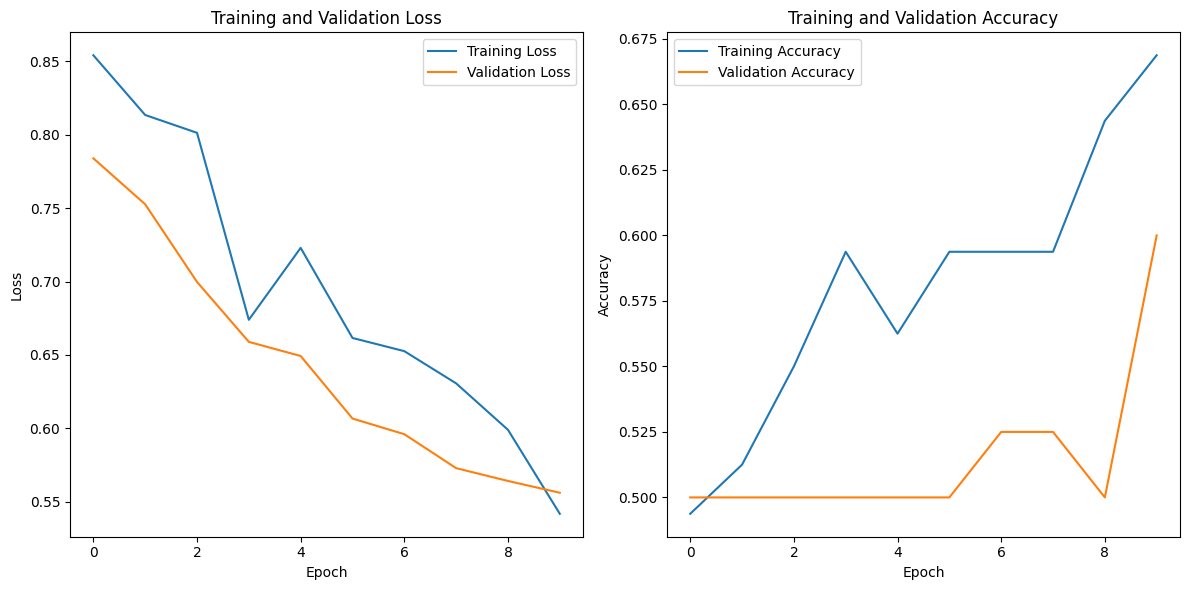

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('baseline_resnet50.keras')

### Summary:

*   Based on the learning curves, we could tuning the base ResNet50 model (unfreezing some layers) with a lower learning rate to potentially improve performance.
